## Beta-2 adrenergic receptor - part 3 (rule aggregation)

### Import libraries

In [1]:
import pandas as pd

### Read in the datasets

In [2]:
df = pd.read_csv('beta2_agonists_stripped.csv')
df_pairs = pd.read_csv('beta2_agonists_pairs.csv')

### Filter pairs with MCS > 70% and radius 3

In [3]:
df_pairs = df_pairs[(df_pairs.percentmcs > 0.70) & (df_pairs.radius == 3)]

### Determine which measurements can be included in delta property calculation

In [4]:
df['pchembl_exact'] = df.apply(lambda x: x.pchembl_value if x.standard_relation == "=" and x.pchembl_value else None, axis=1)

### Combine twice with confirmed molecular pairs

In [5]:
df_merge = df_pairs.merge(df, left_on='smiles1', right_on='stripped_smiles')
df_merge = df_merge.merge(df, left_on=['smiles2', 'target_pref_name', 'standard_type'], right_on=['stripped_smiles', 'target_pref_name', 'standard_type'])
df_merge['pchembl_exact_delta'] = df_merge['pchembl_exact_y'] - df_merge['pchembl_exact_x'] 
df_merge.sample(3).transpose()

,7622,168448,20012
smiles1,CNCC(O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CNC[C@@H](O)c1ccc(O)c(O)c1
smiles2,NCC(O)c1ccc(O)c(O)c1,CNCC(O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1
percentmcs,0.846154,0.8,0.733333
radius,3,3,3
valid,True,True,True
...,...,...,...
ligand_efficiency.bei_y,NaN,NaN,29.82
ligand_efficiency.le_y,NaN,NaN,0.57
stripped_smiles_y,NCC(O)c1ccc(O)c(O)c1,CNCC(O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1
pchembl_exact_y,4.85,NaN,6.3


### Aggregate data by the two fragments

In [6]:
indexcols = ['fragment1', 'fragment2', 'radius', 'target_pref_name', 'standard_type'] #, 'assay_chembl_id', 'standard_units']
df_agg_data = pd.pivot_table(df_merge, values='pchembl_exact_delta', index=indexcols, aggfunc=['count','mean'])
df_agg_data.columns = ['_'.join(col).strip() for col in df_agg_data.columns.values]

### Retain single SMIRKS per transformation (effectively at random)

In [7]:
df_agg_smirks = pd.pivot_table(df_merge, values='smirks', index=indexcols, aggfunc='first')
df_agg = df_agg_data.join(df_agg_smirks).reset_index()

### Write to file

In [8]:
df_agg.to_csv('beta2_agonists_transformations.csv', index=False)

In [9]:
from rdkit import Chem

smirks = df_agg.sample(1)

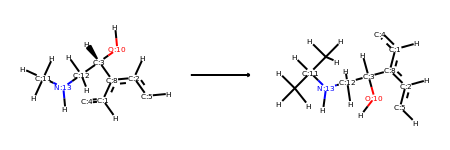

In [10]:
Chem.rdChemReactions.ReactionFromSmarts(smirks.smirks.to_list()[0])